In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<02:00, 1.28kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<03:03, 2.79kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<03:01, 2.68kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<03:42, 4.14kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<07:01, 14.6kB/s]


In [2]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [3]:
import shutil
import os

input_dir = '/kaggle/input/dataset-in-yolo/DataSet/data_fold0'  # Update this with your dataset's name
output_dir = 'data_fold0'  # You can customize the output folder name

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Copy the entire directory
shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)

print(f'Files from {input_dir} have been copied to {output_dir}.')


Files from /kaggle/input/dataset-in-yolo/DataSet/data_fold0 have been copied to data_fold0.


In [4]:
ls

data_fold0/


In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 150

SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [6]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [8]:
fold_df = pd.read_csv('/kaggle/input/5folds/5folds.csv')

In [9]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [10]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

In [11]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [12]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [13]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [14]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [15]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [16]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
47937,4224446605,Right Neural Foraminal Narrowing,L3/L4,Normal/Mild,0,2878505045,4,190.353760,206.083565,Sagittal T1
47938,4224446605,Right Neural Foraminal Narrowing,L4/L5,Normal/Mild,0,2878505045,4,186.788301,247.086351,Sagittal T1
47939,4224446605,Right Neural Foraminal Narrowing,L5/S1,Normal/Mild,0,2878505045,4,197.128134,292.011142,Sagittal T1


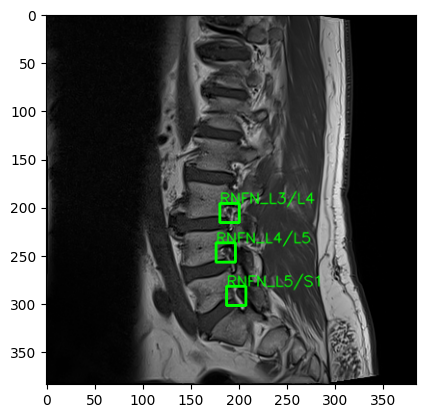

In [17]:
plt.imshow(img)
plt.show()

In [18]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [19]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]


In [20]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [21]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

In [22]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

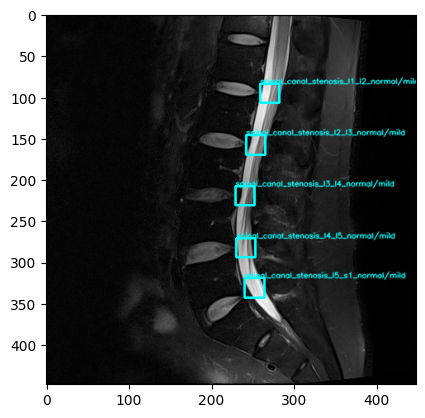

In [23]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [24]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-74m3lmom
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-74m3lmom
  Resolved https://github.com/ultralytics/ultralytics.git to commit 060214d0666258660a018f86874114990873a6a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.1-py3-none-any.whl size=881418 sha256=8e39ac3fc700ab3db03735d55daab0fe7c1a0096964d86cf9f33f4ad664611ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-xd3fqs3f/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [25]:
import os
import numpy as np
from collections import Counter

def calculate_class_weights_from_yolo(annotations_folder, num_classes):
    # Initialize a counter for all class occurrences
    class_counter = Counter()
    
    # Iterate through all annotation files in the folder
    for annotation_file in os.listdir(annotations_folder):
        if annotation_file.endswith('.txt'):  # Assuming YOLO annotations are in .txt files
            with open(os.path.join(annotations_folder, annotation_file), 'r') as file:
                # Read each line in the file
                for line in file:
                    # The first value in each line is the class_id
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    
    # Total number of samples (i.e., total number of objects/annotations)
    total_samples = sum(class_counter.values())
    
    # Calculate class weights using inverse frequency
    class_weights = {cls: total_samples / count for cls, count in class_counter.items()}
    
    # Normalize the weights (optional)
    max_weight = max(class_weights.values())
    class_weights_normalized = {cls: weight / max_weight for cls, weight in class_weights.items()}
    
    return class_weights_normalized

# Example usage
annotations_folder = '/kaggle/working/data_fold0/labels/train/'  # Folder containing YOLO .txt annotation files
num_classes = 15  # Total number of classes in your dataset

class_weights = calculate_class_weights_from_yolo(annotations_folder, num_classes)
print("Class Weights:", class_weights)


Class Weights: {0: 0.010451045104510451, 3: 0.01096997690531178, 7: 0.08260869565217392, 11: 0.07480314960629922, 13: 0.3725490196078432, 6: 0.011721159777914868, 12: 0.01, 4: 0.12751677852348994, 9: 0.012829169480081028, 10: 0.08016877637130802, 5: 0.3584905660377359, 8: 0.1557377049180328, 1: 0.2923076923076924, 2: 0.9047619047619049, 14: 1.0}


In [26]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [27]:
ls

data_fold0/


In [28]:
# %%writefile yolo.yaml
# path: /kaggle/working/data_fold0 # dataset root dir
# train: images/train  
# val: images/val 
# test: images/val 

# # Classes
# names:
#     0: spinal_canal_stenosis_l1_l2_normal/mild
#     1: spinal_canal_stenosis_l1_l2_moderate
#     2: spinal_canal_stenosis_l1_l2_severe
#     3: spinal_canal_stenosis_l2_l3_normal/mild
#     4: spinal_canal_stenosis_l2_l3_moderate
#     5: spinal_canal_stenosis_l2_l3_severe
#     6: spinal_canal_stenosis_l3_l4_normal/mild
#     7: spinal_canal_stenosis_l3_l4_moderate
#     8: spinal_canal_stenosis_l3_l4_severe
#     9: spinal_canal_stenosis_l4_l5_normal/mild
#     10: spinal_canal_stenosis_l4_l5_moderate
#     11: spinal_canal_stenosis_l4_l5_severe
#     12: spinal_canal_stenosis_l5_s1_normal/mild
#     13: spinal_canal_stenosis_l5_s1_moderate
#     14: spinal_canal_stenosis_l5_s1_severe
  

In [29]:
%%writefile my.yaml

path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: spinal_canal_stenosis_l1_l2_normal/mild
    1: spinal_canal_stenosis_l1_l2_moderate
    2: spinal_canal_stenosis_l1_l2_severe
    3: spinal_canal_stenosis_l2_l3_normal/mild
    4: spinal_canal_stenosis_l2_l3_moderate
    5: spinal_canal_stenosis_l2_l3_severe
    6: spinal_canal_stenosis_l3_l4_normal/mild
    7: spinal_canal_stenosis_l3_l4_moderate
    8: spinal_canal_stenosis_l3_l4_severe
    9: spinal_canal_stenosis_l4_l5_normal/mild
    10: spinal_canal_stenosis_l4_l5_moderate
    11: spinal_canal_stenosis_l4_l5_severe
    12: spinal_canal_stenosis_l5_s1_normal/mild
    13: spinal_canal_stenosis_l5_s1_moderate
    14: spinal_canal_stenosis_l5_s1_severe

# Add class weights
weights:
    0: 0.010451045104510451
    1: 0.2923076923076924
    2: 0.9047619047619049
    3: 0.01096997690531178
    4: 0.12751677852348994
    5: 0.3584905660377359
    6: 0.011721159777914868
    7: 0.08260869565217392
    8: 0.1557377049180328
    9: 0.012829169480081028
    10: 0.08016877637130802
    11: 0.07480314960629922
    12: 0.01
    13: 0.3725490196078432
    14: 1.0


Writing my.yaml


In [33]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandbkey")
wandb.login(key=secret_value_0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [34]:
# Initialize W&B run
wandb.init(
    project="Project_Lumbar_Spine_Stenosis",
#     name=f"Demo_fold0",
#     tags=["baseline", "search-lr", ],
    group=";".join(CONDITIONS),
#     config={
#         "lr": LR,
#         "model-name":"xtremedistill-trim",
#         "dataset": [
#             "raw_compettion",
#             "MPWare",
#             "Nicholas"
#         ]
#     }
)

In [35]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO("yolov8s.pt")

# Add W&B callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune your model
# At the end of each epoch, predictions on validation batches are logged
# to a W&B table with insightful and interactive overlays for
# computer vision tasks
history = model.train(project="roject_Lumbar_Spine_Stenosis", data="my.yaml", 
            epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE)

# Finish the W&B run
wandb.finish()

Ultralytics 8.3.1 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=my.yaml, epochs=150, time=None, patience=100, batch=64, imgsz=384, save=True, save_period=-1, cache=False, device=None, workers=8, project=roject_Lumbar_Spine_Stenosis, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning /kaggle/working/data_fold0/labels/train.cache... 2522 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2522/2522 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val.cache... 509 images, 0 backgrounds, 0 corrupt: 100%|██████████| 509/509 [00:00<?, ?it/s]


Plotting labels to roject_Lumbar_Spine_Stenosis/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to roject_Lumbar_Spine_Stenosis/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      11.7G      3.973      6.039       2.03        161        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        509       1950          0          0          0          0
Ultralytics 8.3.1 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      12.3G      2.085      2.772     0.9997        144        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        509       1950     0.0368      0.297      0.116     0.0295


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      11.7G      1.886       1.82     0.9699        112        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        509       1950     0.0632      0.629      0.194     0.0737


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      12.1G      1.817        1.6     0.9583        139        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        509       1950      0.529      0.276      0.323      0.144


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      11.7G      1.763      1.477     0.9459        159        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.486       0.46      0.421      0.161


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      12.2G      1.741      1.386     0.9446        127        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.367      0.674      0.469      0.227


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      12.2G      1.772      1.375     0.9428        143        384: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950      0.441      0.631      0.547       0.27


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      12.2G      1.711      1.293     0.9373        146        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        509       1950      0.451      0.539      0.484      0.157


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      11.7G      1.701      1.296     0.9337        125        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.468      0.598      0.522      0.242


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      11.8G      1.712       1.26     0.9366        155        384: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.544      0.597       0.51      0.246


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      11.7G       1.68      1.236     0.9302        204        384: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        509       1950      0.456      0.621      0.548      0.239


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      11.7G      1.656      1.204     0.9259        120        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.514       0.68      0.556      0.265


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      11.7G      1.658      1.172     0.9277        100        384: 100%|██████████| 40/40 [00:16<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.564      0.617      0.589      0.302


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      11.7G      1.653      1.177      0.923        144        384: 100%|██████████| 40/40 [00:16<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        509       1950      0.434      0.638      0.561      0.242


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      11.8G       1.65      1.184     0.9225        100        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        509       1950       0.49      0.666      0.579      0.302


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      11.7G      1.655       1.16     0.9254        108        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        509       1950       0.52      0.614      0.596       0.31


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      11.7G      1.666      1.163     0.9266        160        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        509       1950       0.51      0.658      0.567      0.291


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      12.2G      1.648      1.131     0.9216        146        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        509       1950      0.476      0.701      0.589      0.301


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      12.1G      1.621      1.143     0.9194        155        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        509       1950      0.492      0.656      0.588      0.304


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      11.7G      1.626      1.149     0.9223        167        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.487      0.703      0.574      0.289


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      11.7G       1.63       1.13     0.9205        158        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        509       1950       0.58      0.639      0.631      0.325


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      11.7G      1.615      1.134     0.9221        110        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.529      0.668      0.608      0.312


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      11.7G      1.624      1.124     0.9174        150        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950      0.567      0.638      0.609      0.281


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      11.7G      1.609      1.113     0.9158        147        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        509       1950      0.502      0.737        0.6       0.29


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      11.7G        1.6      1.105     0.9186        137        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        509       1950      0.538      0.684      0.619      0.307


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      11.7G       1.58      1.107     0.9166        109        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        509       1950      0.519      0.695      0.638      0.332


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      11.8G      1.594      1.093     0.9113        132        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        509       1950      0.508      0.661      0.585      0.299


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      11.7G      1.603      1.088     0.9143        123        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.575      0.619      0.633      0.331


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      12.2G      1.583      1.082     0.9148        121        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.558      0.719      0.616       0.33


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      11.7G      1.593      1.099     0.9134        128        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.602      0.728      0.641      0.347


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      11.7G       1.58      1.072     0.9105        147        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.557      0.646      0.641      0.343


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      11.7G      1.562      1.044     0.9147        128        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        509       1950       0.59      0.742      0.629       0.34


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      11.7G      1.563      1.067     0.9119        133        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.523      0.696      0.611      0.304


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      11.8G      1.579      1.069     0.9132        136        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.573      0.662      0.632      0.334


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      11.7G      1.559      1.075     0.9125        134        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.573      0.713      0.653      0.345


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      11.7G      1.555      1.055     0.9108        119        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.538      0.686       0.63      0.349


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      12.2G      1.559      1.049     0.9085        144        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950      0.537      0.732      0.641      0.356


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      12.2G      1.551       1.05     0.9126        133        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.509      0.756      0.653       0.36


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      11.7G      1.543      1.041     0.9086        153        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        509       1950       0.54      0.755      0.669      0.352


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      11.7G      1.546       1.03     0.9095        119        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.515      0.788      0.677      0.383


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      12.2G      1.553      1.041     0.9126        118        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.595      0.715      0.607      0.311


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      11.7G      1.547      1.046     0.9104        153        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        509       1950      0.539      0.734      0.626      0.323


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      11.7G       1.54      1.026     0.9072        149        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.556      0.742      0.638      0.336


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      11.7G       1.54      1.022     0.9056        163        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.552      0.693      0.661      0.362


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      12.2G      1.538      1.023     0.9025        122        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        509       1950        0.6      0.693      0.648      0.351


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      11.7G      1.525      1.018      0.909        108        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.584      0.723      0.685       0.37


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      11.7G      1.546      1.024     0.9071        115        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        509       1950      0.595      0.693      0.666      0.368


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      11.7G      1.533      1.013     0.9094        150        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        509       1950      0.555      0.731      0.642      0.351


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      11.7G      1.533      1.017     0.9043        145        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        509       1950      0.575      0.729      0.689      0.394


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      11.7G      1.516      1.001     0.9029        143        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        509       1950      0.588      0.672      0.662      0.374


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      11.7G      1.519      1.002     0.9035        149        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.616       0.74      0.683       0.33


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      11.7G      1.526     0.9937     0.9056        152        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.582      0.723      0.668      0.383


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      11.7G       1.51     0.9801     0.9015        134        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.622      0.743      0.702      0.391


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      11.7G      1.523     0.9973     0.9022        163        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.602      0.782      0.695      0.387


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      11.7G      1.507     0.9904     0.9009         81        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.613      0.752      0.697      0.397


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      11.7G      1.514     0.9899     0.9029        146        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        509       1950      0.605      0.716      0.685      0.392


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      12.2G      1.507     0.9716      0.899        116        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.646      0.707      0.688      0.376


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      12.1G      1.497     0.9707        0.9        151        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.602      0.819      0.703      0.389


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      11.7G      1.497     0.9909     0.9009        123        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.615       0.68      0.687      0.402


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      11.7G       1.52     0.9826     0.9058        159        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.599      0.721      0.698      0.396


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      12.2G       1.48     0.9714     0.8989        141        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.613      0.725      0.701      0.397


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      11.7G       1.51     0.9812     0.9041        157        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        509       1950      0.591      0.745      0.687      0.393


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      12.2G       1.49     0.9677     0.8964        184        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.656      0.694       0.71      0.388


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      12.2G      1.496     0.9687     0.9034        117        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.584      0.776       0.71      0.388


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      11.8G      1.485     0.9822     0.8999        107        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        509       1950      0.571      0.798      0.721      0.394


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      11.8G      1.489     0.9695     0.9027        119        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.619      0.745      0.727        0.4


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      11.7G       1.49     0.9627     0.8984        159        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.645      0.701      0.716      0.382


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      11.7G       1.49     0.9439     0.8966        151        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.593      0.788      0.719      0.403


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      11.7G      1.471     0.9439     0.8969        112        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.613      0.818       0.73      0.433


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      12.2G      1.468      0.954     0.8946        136        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.671      0.708      0.713      0.412


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      11.7G       1.49      0.951     0.8993        169        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.608      0.765      0.716      0.424


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      12.2G      1.471     0.9432     0.8986        168        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.597       0.81      0.724      0.416


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      11.7G       1.47     0.9586     0.8988        158        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        509       1950      0.532      0.807      0.716      0.419


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      11.7G      1.473     0.9468     0.8964        161        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.685       0.77      0.724      0.407


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      11.7G      1.474     0.9536     0.8995        116        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.649      0.808       0.75      0.435


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      12.2G      1.473     0.9622     0.8979        125        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.701      0.798      0.761      0.411


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      11.7G      1.466     0.9403     0.8944        194        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.603      0.829      0.732       0.43


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      11.7G      1.452     0.9275     0.8942        138        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.651      0.806      0.752      0.451


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      11.7G      1.451      0.926     0.8957        140        384: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.691       0.71      0.755      0.436


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      11.7G       1.45     0.9207     0.8953        150        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.673      0.733      0.749       0.42


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      11.7G      1.445     0.9221     0.8952        103        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.659       0.73      0.718      0.424


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      11.7G      1.437      0.898     0.8914        176        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        509       1950      0.725      0.729      0.774      0.449


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      11.7G       1.45     0.9134      0.894        118        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.706      0.762      0.761       0.44


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      11.8G      1.441     0.9052     0.8943        120        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        509       1950      0.673      0.724      0.736       0.45


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      11.7G      1.433     0.9082     0.8945        129        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.688      0.744      0.739      0.456


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      12.2G      1.438     0.9118     0.8951        137        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        509       1950      0.658      0.813      0.746      0.439


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      11.7G      1.422     0.8985     0.8911        149        384: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950      0.649      0.777      0.763       0.46


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      11.7G      1.451     0.9082     0.8949        141        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.637      0.825       0.78      0.468


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      11.7G       1.43     0.8971     0.8897        133        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.648      0.784      0.768      0.473


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      11.7G      1.429     0.8974      0.894        133        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.666       0.82      0.785      0.487


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      11.7G      1.415     0.8803     0.8911        154        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.715      0.743      0.786      0.485


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      12.2G      1.428     0.8877     0.8923        148        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.742      0.742      0.785      0.478


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      11.7G      1.428        0.9     0.8922        153        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.723      0.757      0.789      0.477


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      11.7G      1.408     0.8967     0.8923        120        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        509       1950       0.73       0.73      0.778      0.474


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      11.7G      1.416     0.8892     0.8884        117        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950       0.75      0.752      0.797      0.485


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      11.7G      1.398     0.8725     0.8873        113        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.688      0.799      0.792      0.484


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      11.7G      1.409     0.8724     0.8885        138        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.664      0.849      0.782      0.477


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      11.7G      1.404     0.8698     0.8918         97        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.746      0.796      0.804       0.49


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      12.2G      1.399     0.8695     0.8868        137        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        509       1950      0.783      0.838      0.819      0.501


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      11.7G      1.408     0.8703     0.8901        155        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.714        0.8      0.811      0.505


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      11.7G      1.391     0.8563     0.8846        127        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.703      0.802      0.822      0.491


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      11.8G      1.405     0.8666       0.89        156        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.731       0.79      0.815      0.497


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      11.7G      1.397     0.8634     0.8869        139        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950       0.72      0.794      0.818      0.509


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      11.7G      1.384     0.8646     0.8824        158        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.762      0.782      0.812      0.475


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      12.2G      1.381     0.8527     0.8875        136        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.746      0.818       0.84      0.515


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      11.7G      1.395     0.8397     0.8853        144        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.793      0.813      0.836      0.495


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      11.7G      1.386     0.8481     0.8843        147        384: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950       0.82      0.772      0.834      0.522


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      11.8G      1.385     0.8405     0.8853        116        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        509       1950      0.771      0.831      0.841      0.515


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      11.7G      1.386     0.8505     0.8859        177        384: 100%|██████████| 40/40 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        509       1950      0.794      0.836      0.842      0.508


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      11.7G      1.365     0.8414     0.8834        154        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.791       0.85      0.863      0.534


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      11.7G      1.369     0.8272     0.8855        147        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.792      0.792      0.836       0.51


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      12.2G      1.361     0.8348     0.8804        155        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.797       0.78      0.856      0.531


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      11.8G      1.345     0.8195     0.8838        121        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.795      0.834      0.863      0.536


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      11.7G      1.374     0.8266     0.8842        148        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.795      0.819      0.866      0.533


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      11.7G      1.359     0.8216     0.8837        135        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        509       1950      0.778      0.838      0.847      0.538


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      12.2G      1.358     0.8263     0.8829        118        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.783      0.819      0.861      0.553


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      11.7G      1.349     0.8005     0.8797        163        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950      0.811      0.825      0.869      0.549


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      11.7G      1.357     0.8231     0.8821         90        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.796      0.836      0.871      0.548


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      12.2G      1.349     0.8115     0.8814        122        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        509       1950       0.78       0.91       0.88      0.556


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      11.7G      1.351     0.8108     0.8783        166        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.763      0.892      0.871      0.544


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      11.7G      1.344     0.7963     0.8816        123        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.789      0.883      0.871      0.563


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      11.7G      1.337     0.7987     0.8779        134        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.748      0.904      0.881      0.559


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      12.2G      1.326     0.7992     0.8777        167        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.798       0.86      0.882      0.556


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      12.2G       1.34     0.7983     0.8796        144        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.782       0.89      0.886      0.566


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      11.7G      1.332     0.7925     0.8765        155        384: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        509       1950      0.793      0.881      0.874      0.558


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      11.7G      1.334     0.7906     0.8799        162        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.792      0.897      0.891      0.581


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      11.7G      1.324     0.7863     0.8771        100        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.797      0.889      0.887      0.569


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      12.2G      1.318     0.7839     0.8732        128        384: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950      0.784      0.912      0.893       0.59


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      11.7G      1.313     0.7852     0.8717        136        384: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.812       0.88      0.893      0.586


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      11.7G       1.32     0.7921     0.8755        190        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950       0.81      0.894      0.897      0.569


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      11.7G      1.315     0.7908      0.879        135        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        509       1950      0.794      0.926      0.897      0.569


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      11.7G       1.31     0.7797     0.8754        109        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.849      0.869      0.901      0.577


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      12.2G      1.307     0.7773     0.8754        103        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.845       0.85        0.9      0.582


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      11.8G      1.308     0.7698     0.8763        158        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.785      0.914      0.898      0.588


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      11.7G      1.292     0.7651     0.8707        171        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        509       1950      0.793      0.916      0.898      0.589


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      11.7G        1.3     0.7708      0.875        144        384: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        509       1950      0.829      0.895      0.899      0.596


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      11.7G      1.301     0.7691     0.8746        171        384: 100%|██████████| 40/40 [00:17<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950       0.83      0.897        0.9      0.587


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      11.8G      1.302     0.7681     0.8747        191        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        509       1950      0.817      0.907      0.905      0.598


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      11.7G      1.299     0.7674     0.8727        161        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.844      0.894      0.906      0.595


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      11.7G      1.294     0.7634     0.8737        118        384: 100%|██████████| 40/40 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        509       1950      0.849      0.901      0.906      0.591


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      11.7G       1.29     0.7163     0.8974         99        384: 100%|██████████| 40/40 [00:18<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        509       1950       0.84      0.896      0.908      0.607


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      11.8G      1.257     0.7007     0.8928        104        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        509       1950      0.851       0.89      0.906      0.607


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      11.8G      1.245     0.7037     0.8903        112        384: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950       0.86        0.9       0.91      0.607


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      11.8G      1.235     0.6951     0.8897        108        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        509       1950      0.845      0.902      0.909      0.617


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      12.2G      1.227     0.6921     0.8853        105        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        509       1950      0.835      0.917      0.913      0.614


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      11.7G       1.23     0.6896     0.8891        113        384: 100%|██████████| 40/40 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.841      0.919      0.915      0.622


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      11.8G      1.221     0.6865     0.8853         97        384: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        509       1950      0.842      0.922      0.913      0.623


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      12.2G      1.216     0.6821     0.8827         98        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        509       1950      0.853      0.918      0.913      0.627


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      11.8G      1.223     0.6825     0.8881         97        384: 100%|██████████| 40/40 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.855       0.91      0.913      0.623


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      11.8G      1.217     0.6827     0.8858        106        384: 100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        509       1950      0.851       0.92      0.915      0.623


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


150 epochs completed in 2.241 hours.
Optimizer stripped from roject_Lumbar_Spine_Stenosis/train/weights/last.pt, 19.9MB
Optimizer stripped from roject_Lumbar_Spine_Stenosis/train/weights/best.pt, 19.9MB

Validating roject_Lumbar_Spine_Stenosis/train/weights/best.pt...
Ultralytics 8.3.1 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 9,833,469 parameters, 0 gradients, 23.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


                   all        509       1950      0.853      0.918      0.913      0.627
spinal_canal_stenosis_l1_l2_normal/mild        369        369       0.87       0.97      0.913      0.564
spinal_canal_stenosis_l1_l2_moderate          9          9      0.825      0.889      0.943      0.663
spinal_canal_stenosis_l1_l2_severe          2          2      0.876          1      0.995      0.722
spinal_canal_stenosis_l2_l3_normal/mild        350        350      0.877      0.971      0.942      0.575
spinal_canal_stenosis_l2_l3_moderate         27         27      0.714      0.815      0.853      0.614
spinal_canal_stenosis_l2_l3_severe          8          8      0.858      0.875      0.847      0.648
spinal_canal_stenosis_l3_l4_normal/mild        325        325      0.931      0.975      0.979       0.64
spinal_canal_stenosis_l3_l4_moderate         43         43      0.838      0.977      0.916      0.655
spinal_canal_stenosis_l3_l4_severe         27         27      0.833      0.924    

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to roject_Lumbar_Spine_Stenosis/train


lr/pg0,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁
lr/pg1,▃▆████▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
lr/pg2,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁
metrics/mAP50(B),▁▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇███████████
metrics/mAP50-95(B),▁▂▄▄▄▄▅▅▅▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇██████
metrics/precision(B),▂▁▁▂▂▃▄▃▃▄▃▃▄▄▄▅▄▄▄▅▅▆▆▅▅▆▅▇▆▆▇▇▇▇███▇██
metrics/recall(B),▁▄▄▂▃▄▅▄▄▅▄▅▄▅▅▅▄▅▆▅▆▆▅▆▅▇▆▆▇▆▇▇▇█▇█▇█▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁


In [57]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


spinal_canal_stenosis_l3_l4_normal/mild
spinal_canal_stenosis_l4_l5_severe
spinal_canal_stenosis_l5_s1_normal/mild


In [58]:
# Initialize YOLO Model
model = YOLO(glob.glob("/kaggle/working/roject_Lumbar_Spine_Stenosis/train/weights/best.pt")[0])

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Perform prediction which automatically logs to a W&B Table
# with interactive overlays for bounding boxes, segmentation masks
out = model.predict([path], save=True, conf=0.2)
# Finish the W&B run
wandb.finish()


0: 384x384 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 1 spinal_canal_stenosis_l3_l4_normal/mild, 1 spinal_canal_stenosis_l4_l5_severe, 1 spinal_canal_stenosis_l5_s1_normal/mild, 11.4ms
Speed: 3.0ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


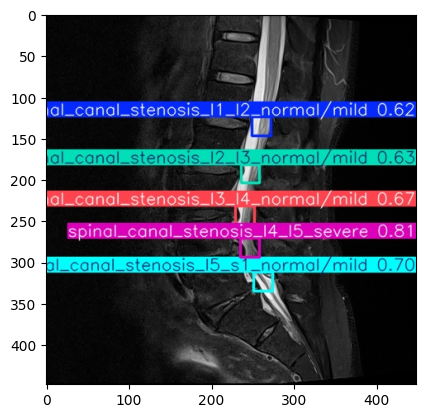

In [59]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)

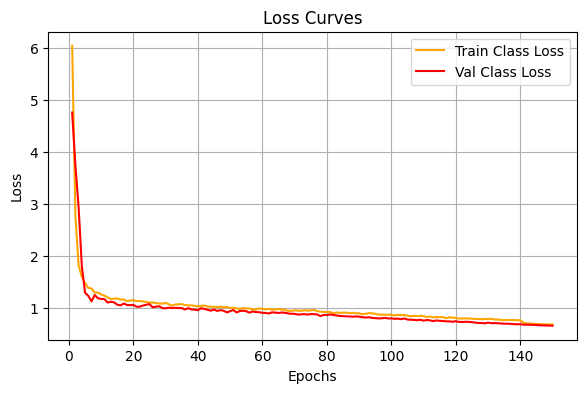

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('/kaggle/working/roject_Lumbar_Spine_Stenosis/train/results.csv')  # Update with the correct path if needed

# Print the first few rows to understand the structure
# print(results_df.head())

# Extracting metrics
epochs = results_df['                  epoch']
train_box_loss = results_df['         train/box_loss']
train_cls_loss = results_df['         train/cls_loss']
val_box_loss = results_df['           val/box_loss']
val_cls_loss = results_df['           val/cls_loss']


# Plotting the curves
plt.figure(figsize=(15, 4))

# Loss Curves
plt.subplot(1, 2, 1)
# plt.plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
plt.plot(epochs, train_cls_loss, label='Train Class Loss', color='orange')
# plt.plot(epochs, val_box_loss, label='Val Box Loss', color='green')
plt.plot(epochs, val_cls_loss, label='Val Class Loss', color='red')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()



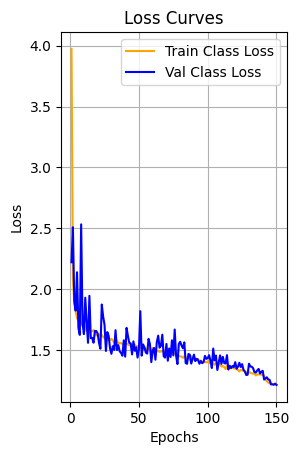

In [75]:
plt.subplot(1, 2, 1)
# plt.plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
plt.plot(epochs, train_box_loss, label='Train Class Loss', color='orange')
# plt.plot(epochs, val_box_loss, label='Val Box Loss', color='green')
plt.plot(epochs, val_box_loss, label='Val Class Loss', color='blue')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()



image 1/1 /kaggle/input/test-image-1/f7a8adca63efae788f621869cc21e8_gallery.jpg: 384x384 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 1 spinal_canal_stenosis_l3_l4_normal/mild, 1 spinal_canal_stenosis_l4_l5_severe, 1 spinal_canal_stenosis_l5_s1_normal/mild, 17.1ms
Speed: 2.6ms preprocess, 17.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 384)


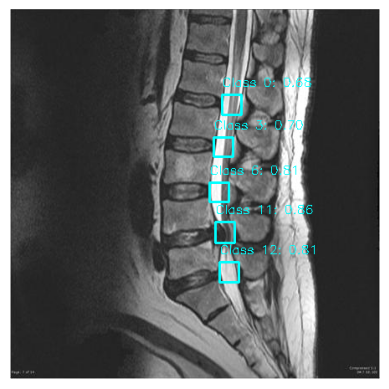

In [87]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained YOLO model
model = YOLO('/kaggle/working/roject_Lumbar_Spine_Stenosis/train/weights/best.pt')

# Specify the path to the unseen image
unseen_image_path = '/kaggle/input/test-image-1/f7a8adca63efae788f621869cc21e8_gallery.jpg'
# Load the image using cv2 for any format (.jpeg, .jpg, .png)
im = cv2.imread(unseen_image_path)

# Convert BGR (OpenCV default) to RGB for displaying in matplotlib
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

H, W = im.shape[:2]

# Make predictions
results = model.predict(unseen_image_path, conf=0.2)  # Adjust confidence as needed

# Draw predicted bounding boxes
for det in results[0].boxes.data.tolist():  # Assuming results are structured like this
    x1, y1, x2, y2, conf, class_id = det
    label = f'Class {int(class_id)}: {conf:.2f}'
    
    # Draw the rectangle and label
    im = cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 2)
    im = cv2.putText(im, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

# Display the result
plt.imshow(im)
plt.axis('off')  # Hide axes
plt.show()


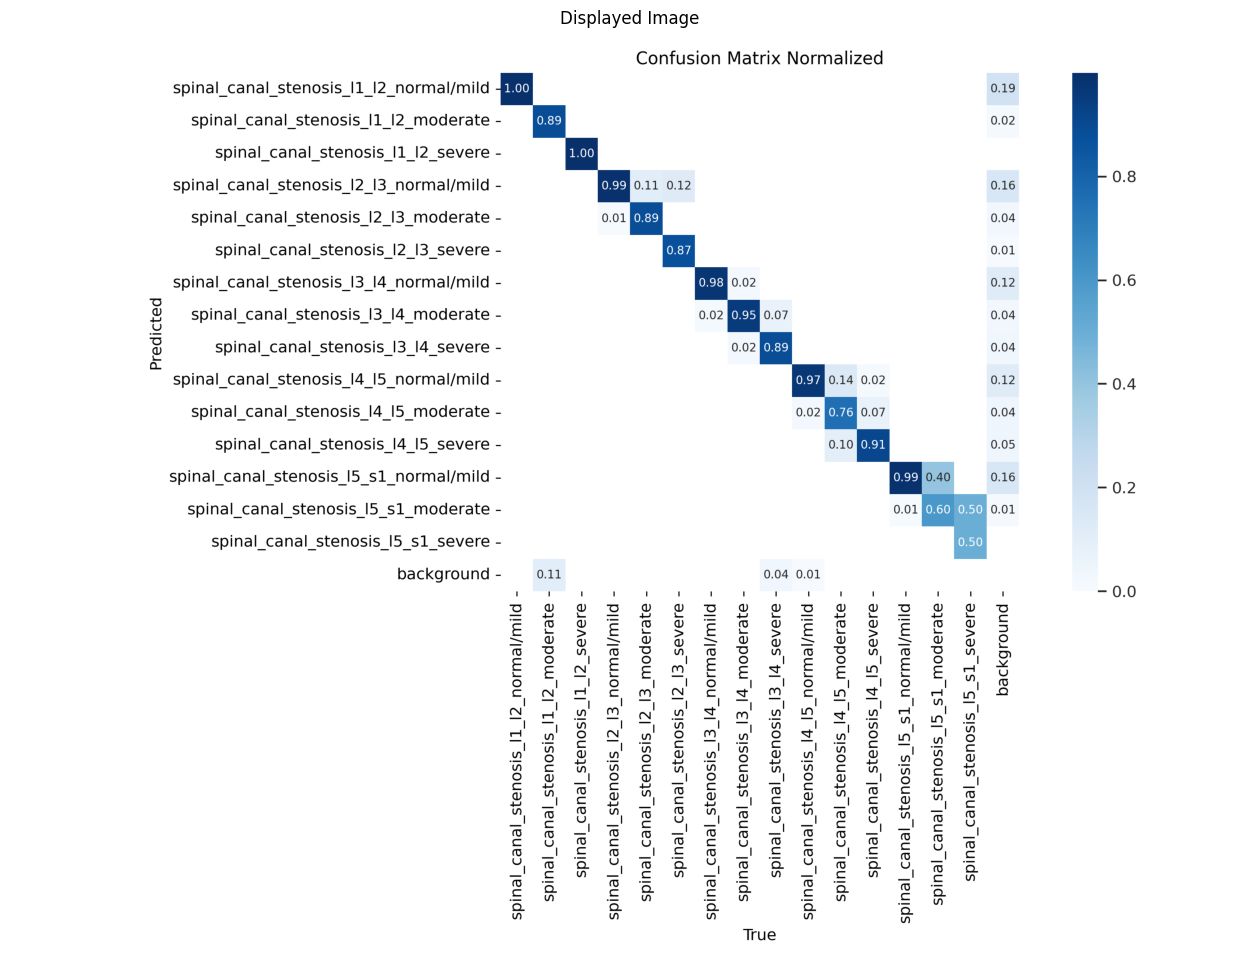

In [69]:
import matplotlib.pyplot as plt
import cv2

# Load the image (replace 'your_image.jpg' with the actual filename)
image_path = '/kaggle/working/roject_Lumbar_Spine_Stenosis/train/confusion_matrix_normalized.png' # Update the path accordingly
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(16, 16))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.title('Displayed Image')
    plt.show()


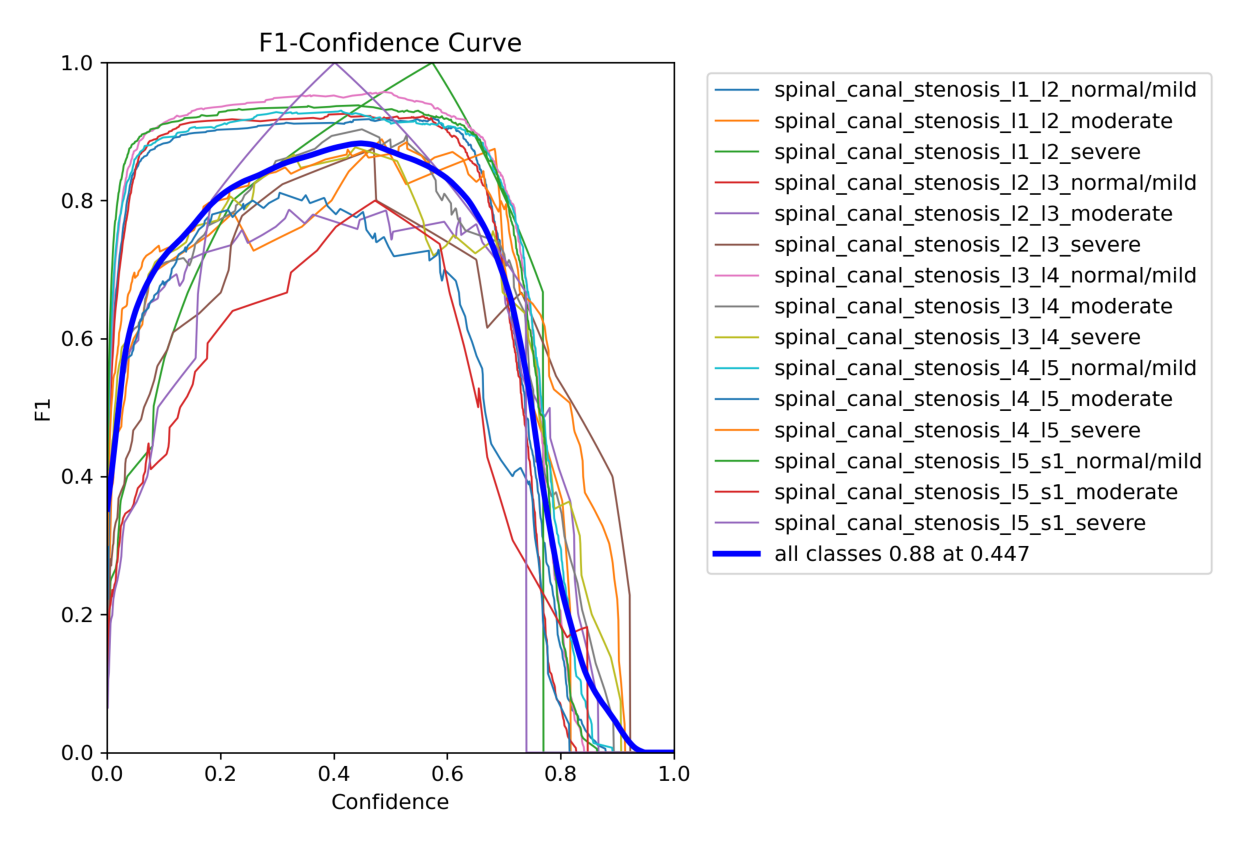

In [76]:
import matplotlib.pyplot as plt
import cv2

# Load the image (replace 'your_image.jpg' with the actual filename)
image_path = '/kaggle/working/roject_Lumbar_Spine_Stenosis/train/F1_curve.png' # Update the path accordingly
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(16, 16))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()


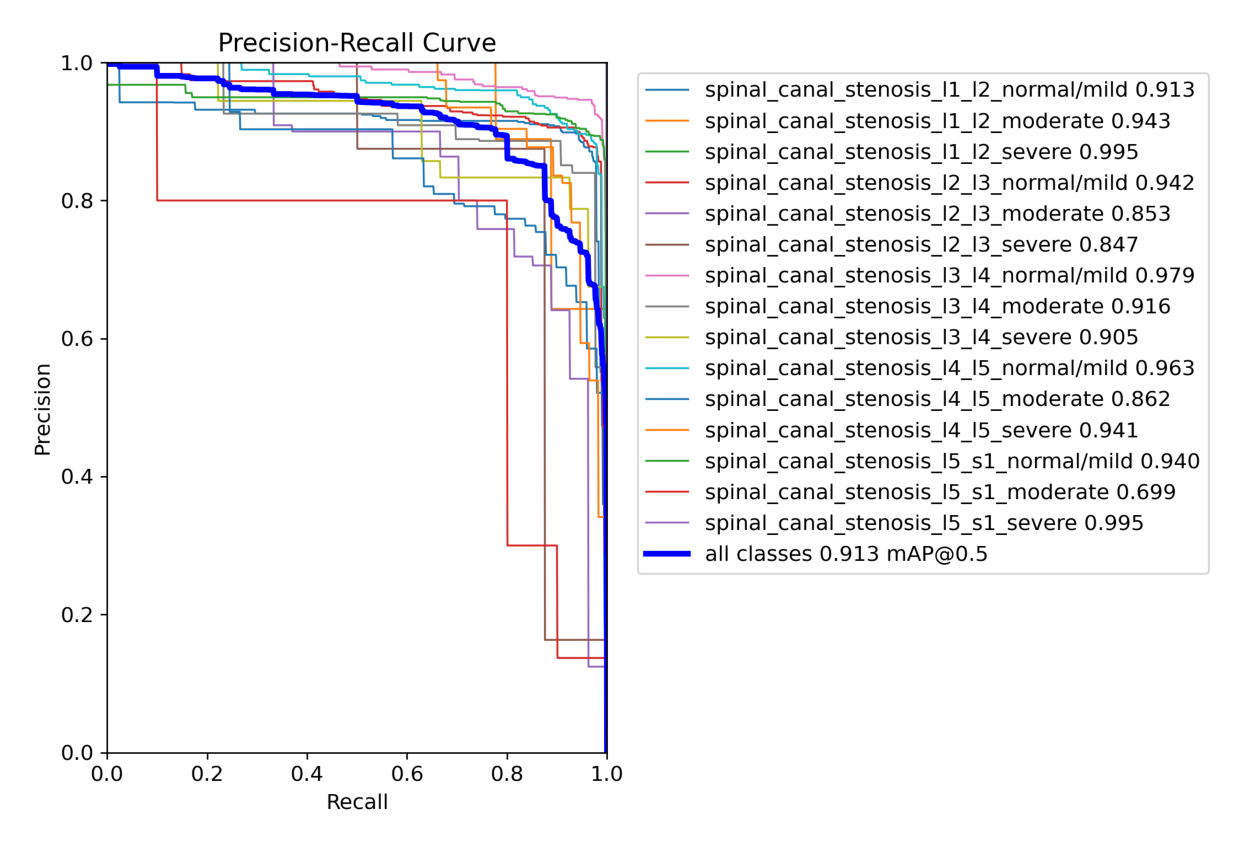

In [78]:
import matplotlib.pyplot as plt
import cv2

# Load the image (replace 'your_image.jpg' with the actual filename)
image_path = '/kaggle/working/roject_Lumbar_Spine_Stenosis/train/PR_curve.png' # Update the path accordingly
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(16, 16))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.show()


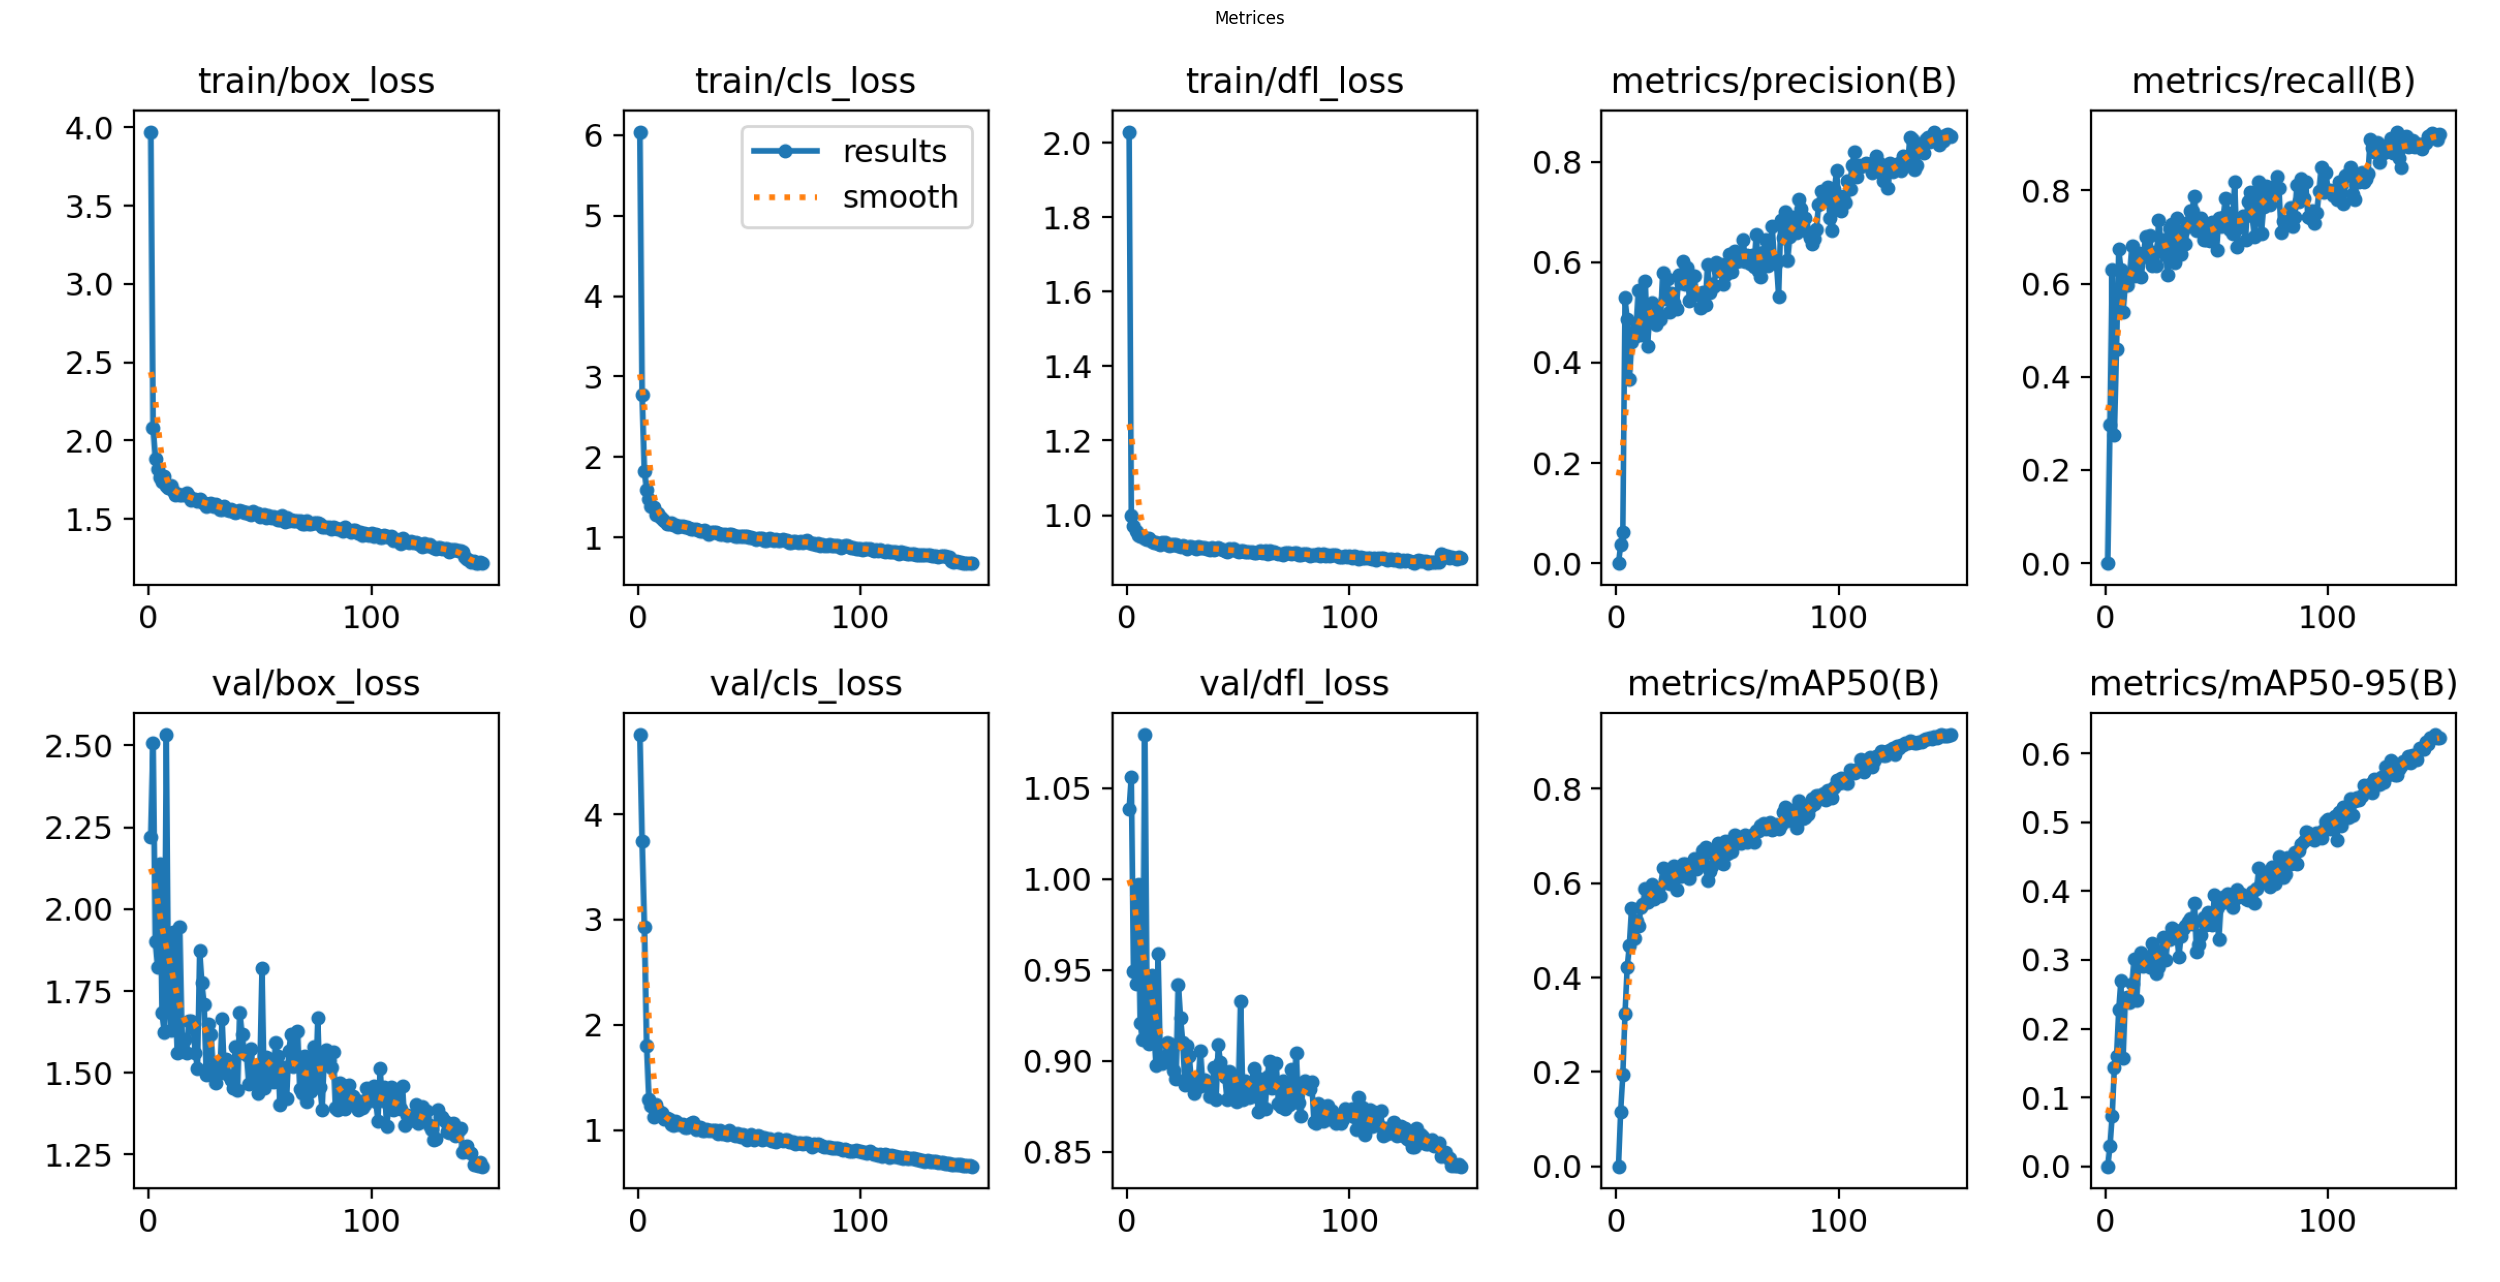

In [72]:
import matplotlib.pyplot as plt
import cv2

# Load the image (replace 'your_image.jpg' with the actual filename)
image_path = '/kaggle/working/roject_Lumbar_Spine_Stenosis/train/results.png' # Update the path accordingly
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(32, 32))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis labels
    plt.title('Metrices')
    plt.show()
